**Import data**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

**Reading files**

In [84]:
df = pd.read_csv('quanti_df_daily.csv')

In [86]:
# set index as 'Date'
df = df.set_index('Date')

In [88]:
df

,gold price,S&P500,DowJones,eur,inr,cny,jpy,gbp,oil price
Date,,,,,,,,,
2014-12-09,1231.500000,2059.820068,17801.199219,0.81201,61.818001,6.1630,120.650002,0.63891,63.820000
2014-12-10,1228.900024,2026.140015,17533.150391,0.80678,61.873001,6.1778,119.342003,0.63743,60.939999
2014-12-11,1225.099976,2035.329956,17596.339844,0.80167,62.002998,6.1666,117.709000,0.63504,59.950001
2014-12-12,1222.000000,2002.329956,17280.830078,0.80678,62.473000,6.1786,119.007004,0.63603,57.810001
2014-12-15,1207.199951,1989.630005,17180.839844,0.80234,62.518002,6.1769,118.165001,0.63581,55.910000
...,...,...,...,...,...,...,...,...,...
2024-12-02,2634.899902,6047.149902,44782.000000,0.94831,84.556999,7.2407,149.897995,0.78730,68.099998
2024-12-03,2644.699951,6049.879883,44705.531250,0.95227,84.737099,7.2709,149.507996,0.78998,69.940002
2024-12-04,2653.800049,6086.490234,45014.039062,0.95140,84.683098,7.2838,149.647003,0.78900,68.540001


In [90]:
import pandas as pd

# Create lag features for the target variable (gold price)
def create_lag_features(df, target_col, lags=3):
    for lag in range(1, lags + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

df = create_lag_features(df, 'gold price', lags=3)
df = df.dropna()  # Drop rows with NaN values due to lagging


In [100]:
from sklearn.model_selection import train_test_split

# Define target (y) and features (X)
y = df['gold price']
X = df.drop(columns=['gold price'])

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [102]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define model parameters
params = {
    'objective': 'reg:squarederror',  # For regression
    'max_depth': 6,
    'eta': 0.1,  # Learning rate
    'eval_metric': 'rmse'
}

# Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred = xgb_model.predict(dtest)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


Mean Absolute Error: 219.83737729745081
Mean Squared Error: 110145.96934120983


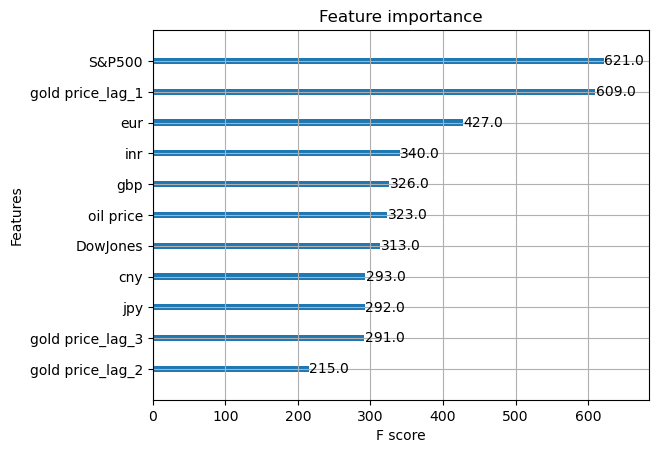

In [103]:
# Plot feature importance
xgb.plot_importance(xgb_model)
plt.show()


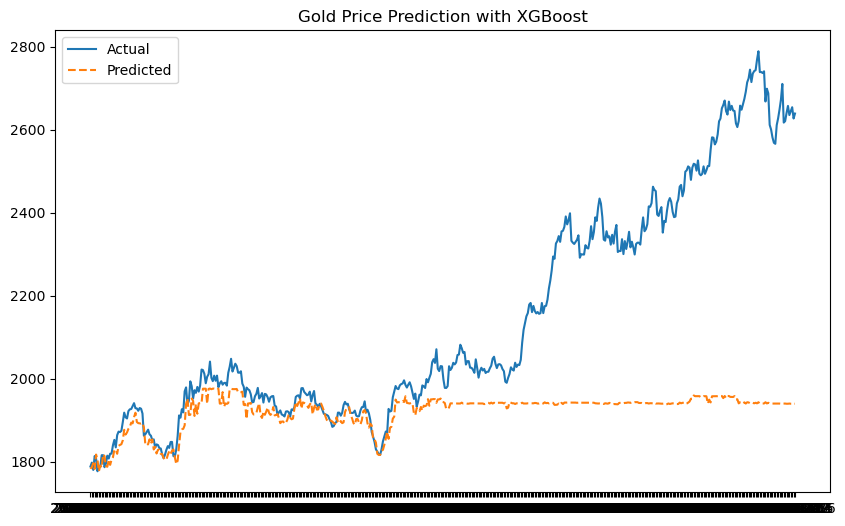

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted", linestyle="--")
plt.legend()
plt.title("Gold Price Prediction with XGBoost")
plt.show()
